**Part 1:** 

Use the **Fashion-MNIST** dataset for this question.

1a) Load the dataset and implement the K Means algorithm. You need to find the optimal number of clusters using the
> i) elbow method

> ii) silhoette method



1b) Define the initial clusters’ centroids using:</br>
> i) Forgy</br>

> ii) Random Partition

1c) Experiment with different distance measures [Euclidean distance, Manhattan distance].

1d) Plot the error vs number of clusters graph while using the elbow method and silhouette 
    method. Report the optimal number of clusters found.


1e) Visualize the dataset to depict the clusters formed. (prefer T-SNE)

</br>
</br>
</br>
</br>


**Part 2:**
</br>
In this task, you need to implement Hierarchical clustering (agglomerative) on the same dataset.

2a) visualize a dendogram and find out the optimal number of clusters with the help of Dendogram. Explain the procedure.


2b) Implement Hierarchical clustering using: </br>
> i) single linkage

> ii) Complete linkage

>Visualize the clusters obtained using these linkages and compare. 



In [3]:
# Getting data
import pandas as pd
data_pd = pd.read_csv('./archive/fashion-mnist_test.csv')
# data_pd['label'].head(5)
data_without_labels = data_pd.drop(labels=['label'], axis=1)
data_without_labels.head(5)
data = data_without_labels.to_numpy(dtype=float)[:1000]
print(data[0:5])
print(data.shape)
# data_without_labels = data_pd.drop(labels=['label']) # .head(5)
# load dataset
# (trainX, trainy), (testX, testy) = fashion_mnist.load_data()

[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ... 56.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
(1000, 784)


In [61]:
# implement Kmeans from scratch
import random
import numpy as np



class Kmeans:
    def __init__(self, k=3, tolerance=0.001, max_iter=300, init_clusters='forgy', d_measure='euclidean'):
        '''
        init_clusters: 'forgy' or 'random_partition'
        d_measure: 'euclidean' or 'manhattan'
        '''
        self.k = k
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.init_clusters = init_clusters
        self.distance = None
        if d_measure == 'euclidean':
            self.distance = self.euclidean_measure
        elif d_measure == 'manhattan':
            self.distance = self.manhattan_measure
        else:
            print("Invalid distance measure name given {}, use either 'euclidean' or 'manhattan'".format(d_measure))
            exit()
        self.centroids = {} # contains centroid labels and their feature set
        self.classifications = {} # contains classification labels and all the samples belonging to that label
        self.seed = 11
        random.seed(self.seed)

    def manhattan_measure(self, x1, x2):
        return np.sum(np.abs(x1-x2))

    def euclidean_measure(self, x1, x2):
        return np.linalg.norm(x1-x2)

    def forgy(self, data):
        '''
        Initialize k cluster centroids by choosing k unique points randomly from the dataset
        '''
        self.centroids = {}
        row_indices = []
        # define self.k random centroids
        for i in range(self.k):
            row_index = random.randint(0, len(data)-1)
            while row_index in row_indices:
                row_index = random.randint(len(data)-1)
            self.centroids[i] = data[row_index]
        # return self.centroids

    def random_partition(self, data):
        '''
        Assign a random cluster label to each data point and then proceed to the update step 
        directly from this initialization
        '''
        for i in range(self.k):
            self.classifications[i] = []
        for row in data:
            classification_index = random.randint(0, self.k-1)
            self.classifications[classification_index].append(row)

    def get_nearest_centroid(self, observation):
        '''
        Finds and returns the nearest centroid to the given observation
        '''
        nearest_centroid_index = 0
        nearest_centroid_dist = -1
        for centroid in self.centroids:
            dist = self.distance(self.centroids[centroid], observation)
            if dist < nearest_centroid_dist or nearest_centroid_dist == -1:
                nearest_centroid_dist = dist
                nearest_centroid_index = centroid
        return nearest_centroid_index, nearest_centroid_dist

    def update_cluster_centroids(self):
        for classification in self.classifications:
            if len(self.classifications[classification])==0:
                self.centroids[classification] = 0
            else:
                self.centroids[classification] = np.average(self.classifications[classification], axis=0)

    def assign_cluster_centers_to_data(self, data):
        data_with_labels = {}
        for k in range(len(data)):
                data_with_labels[k] = []
        k = 0
        for row in data:
            nearest_centroid_index, nearest_dist = self.get_nearest_centroid(row)
            data_with_labels[k].append(row)
            data_with_labels[k].append(nearest_centroid_index)
            k+=1
        return data_with_labels

    def get_cluster_counts(self, data):
        cluster_counts = {}
        # Clear previous assignments
        for k in range(self.k):
            cluster_counts[k] = 0
        # Assign cluster centroids to training points
        for row in data:
            nearest_centroid_index, nearest_dist = self.get_nearest_centroid(row)
                # print(nearest_centroid_index, self.classifications)
            cluster_counts[nearest_centroid_index] += 1
        
        return cluster_counts

        # for row in data:
        #         nearest_centroid_index, nearest_dist = self.get_nearest_centroid(row)
        #         # print(nearest_centroid_index, self.classifications)
        #         classifications[nearest_centroid_index].append(row)
                
        # return classifications
        

    def fit(self, data):
        self.centroids = {}
        row_indices = []

        # Cluster initialization
        if self.init_clusters == 'forgy':
            # Declare random points as cluster centroids
            self.forgy(data)
        elif self.init_clusters == 'random_partition':
            # Declare each point as belonging to a particular cluster and then update the cluster centroid
            self.random_partition(data)
            self.update_cluster_centroids()
        else:
            print("Initialization method name is wrong, please check")
            exit()
        

        # Run the main training loop
        prev_cost = -1
        for i in range(self.max_iter):
            # Clear previous assignments
            for k in range(self.k):
                self.classifications[k] = []

            current_cost_before_updates = 0
            # Assign cluster centroids to training points
            for row in data:
                nearest_centroid_index, nearest_dist = self.get_nearest_centroid(row)
                # print(nearest_centroid_index, self.classifications)
                self.classifications[nearest_centroid_index].append(row)
                current_cost_before_updates += nearest_dist

            # Compare previous cost to current, if no change beyond the tolerance, exit
            if abs(current_cost_before_updates - prev_cost) < self.tolerance*len(data):
                print("Optimized!! After {} iterations".format(i+1))
                break
            prev_cost = current_cost_before_updates
            
            # Update cluster centroids
            self.update_cluster_centroids()
        

k = 1
Optimized!! After 3 iterations
k = 2
Optimized!! After 25 iterations
k = 4
Optimized!! After 50 iterations
k = 6
Optimized!! After 34 iterations
k = 8
Optimized!! After 23 iterations
k = 10
Optimized!! After 17 iterations
k = 15
Optimized!! After 24 iterations
k = 19
Optimized!! After 46 iterations
k = 30
Optimized!! After 19 iterations
k = 50
Optimized!! After 9 iterations
k = 100
Optimized!! After 9 iterations
k = 200
Optimized!! After 9 iterations
k = 500
Optimized!! After 5 iterations
k = 999
Optimized!! After 4 iterations


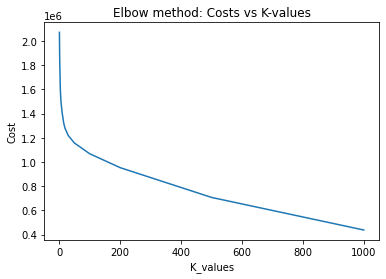

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline
#implement elbow method from scratch
def elbow(data):
    '''
    Plot the k (num of clusters) vs cluster costs and decide which k to use based on where the 'elbow'
    occurs
    '''
    costs = []
    k_vals = []
    vals = [1, 2, 4, 6, 8, 10, 15, 19, 30, 50, 100, 200, 500, 999]
    for i in vals: # range(1, 20):
        print("k = {}".format(i))
        clf = Kmeans(k=i, init_clusters='forgy')
        clf.fit(data)
        cost = 0
        for row in data:
            nearest_ind, nearest_dist = clf.get_nearest_centroid(row)
            cost += nearest_dist
        costs.append(cost)
        k_vals.append(i)
    
    plt.plot(k_vals, costs)
    plt.title(label='Elbow method: Costs vs K-values')
    plt.xlabel(xlabel='K_values')
    plt.ylabel(ylabel='Cost')
elbow(data)

k = 1
Optimized!! After 3 iterations
done!
k = 15
Optimized!! After 24 iterations
done!
k = 19
Optimized!! After 46 iterations
done!
k = 30
Optimized!! After 19 iterations
done!
k = 50
Optimized!! After 9 iterations
done!
k = 500
Optimized!! After 5 iterations
done!
k = 999
Optimized!! After 4 iterations
done!


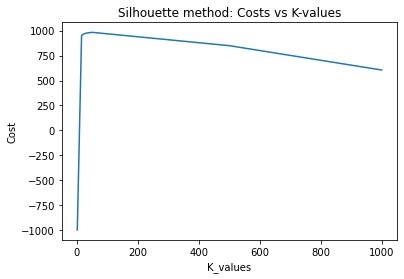

In [62]:
#implement silhouette method from scratch
def silhouette(data):
    silhouette_costs = []
    k_vals = []
    vals = [1, 15, 19, 30, 50, 500, 999]
    for i in vals:# range(1, 20, 2): 
        print("k = {}".format(i))
        clf = Kmeans(k=i, max_iter=300, init_clusters='forgy')
        clf.fit(data)
        # Calculate silhouette cost components
        s = 0
        data_with_labels = clf.assign_cluster_centers_to_data(data)
        data_costs = {}
        for u in range(len(data)):
            data_costs[u] = {'a':0.0, 'b':0.0}
            
        for key in data_with_labels:
            row1 = data_with_labels[key][0]
            label1 = data_with_labels[key][1]
            for key2 in data_with_labels:
                row2 = data_with_labels[key2][0]
                label2 = data_with_labels[key2][1]
                dist = clf.euclidean_measure(row1, row2)
                if label1==label2:
                    data_costs[key]['a'] += dist
                else:
                    data_costs[key]['b'] += dist

        cluster_counts = clf.get_cluster_counts(data)
        print("done!")
        # calculating silhouette costs
        for data_index in data_with_labels:
            row = data_with_labels[data_index][0]
            label = data_with_labels[data_index][1]
            if cluster_counts[label] <= 1:
                continue # s[i] = 0
            a = data_costs[data_index]['a']
            b = data_costs[data_index]['b']
            s += (b-a)/max(b, a)
        # classifications = clf.assign_cluster_centers_to_data(data)
        # for classification in classifications:
        #     if len(classifications[classification]) <= 1:
        #         continue # s[i] = 0
        #     for obs in classifications[classification]:
        #         a = 0
        #         b = 0
        #         for obs2 in classifications[classification]:
        #             a += clf.euclidean_measure(obs, obs2)
        #         for classification2 in classifications:
        #             if classification2==classification:
        #                 continue
        #             for obs2 in classifications[classification2]:
        #                 b += clf.euclidean_measure(obs, obs2)
        #         s += (b-a)/max(b, a)
        silhouette_costs.append(s)
        k_vals.append(i)
    plt.plot(k_vals, silhouette_costs)
    plt.title(label='Silhouette method: Costs vs K-values')
    plt.xlabel(xlabel='K_values')
    plt.ylabel(ylabel='Cost')
                
silhouette(data)

# Answers
Optimal k values are = 19, 30 or 50 (all three are nearly equal and together constitute the edge/elbow in the first graph, maxima in the second graph) (Needs magnified-graph verification)

In [66]:
clf = Kmeans(k=25, init_clusters='forgy')
clf.fit(data)
data_with_labels = clf.assign_cluster_centers_to_data(data)
data_with_labels[0][1]

Optimized!! After 22 iterations


6

In [73]:
data_ordered = []
labels_ordered = []
for key in data_with_labels:
    row1 = data_with_labels[key][0]
    label1 = data_with_labels[key][1]
    data_ordered.append(row1)
    labels_ordered.append(label1)

# set(labels_ordered)

[False]

In [85]:
len(data_ordered[labels_ordered==1])


784

In [102]:
# Visualizing formed clusters
clf = Kmeans(k=20, init_clusters='forgy', tolerance=0.0)
clf.fit(data)
data_with_labels = clf.assign_cluster_centers_to_data(data)

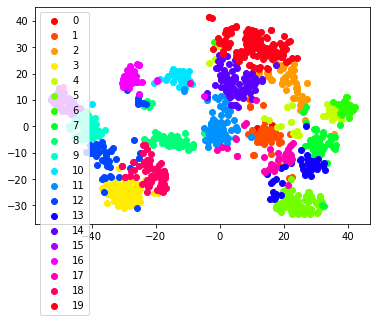

In [103]:
data_ordered = []
labels_ordered = []
for key in data_with_labels:
    row1 = data_with_labels[key][0]
    label1 = data_with_labels[key][1]
    data_ordered.append(row1)
    labels_ordered.append(label1)

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(data_ordered)

data_clusters = {}
for i in range(clf.k):
    data_clusters[i] = []
for i in range(len(labels_ordered)):
    data_clusters[labels_ordered[i]].append(X_2d[i, :])
for i in range(clf.k):
    data_clusters[i] = np.array(data_clusters[i])

# target_ids = range(len(labels_ordered))

from matplotlib import pyplot as plt
hsv = plt.get_cmap('hsv')
colors = hsv(np.linspace(0, 1.0, len(set(labels_ordered))))
for label, color in zip(set(labels_ordered), colors):
    plt.scatter(data_clusters[label][:, 0], data_clusters[label][:, 1], c = np.array([color]), label=label)
    

# plt.figure(figsize=(6, 5))
# colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
# for i, c, label in zip(target_ids, colors, digits.target_names):
#     plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, label=label)
plt.legend()
plt.show()

In [ ]:
from keras.datasets import fashion_mnist
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

# you can performs your training on train/test dataset alone if there are computational issues

Hierarchical clustering

(10000, 785)
(10000, 785)


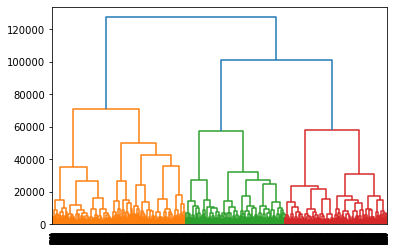

In [14]:
# print(data_pd.head(5))
print(data_pd.values.shape)
print(data_pd.shape)
dendrogram = sch.dendrogram(sch.linkage(data_pd, method='ward'))

In [1]:
# implement hierarchical clustering ( you can use scikit module)
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

def hierarchical_clustering(X, no_of_clusters = 3, affinity='euclidean', linkage='ward'):
    '''
    Info.
    '''
    model = AgglomerativeClustering(n_clusters=no_of_clusters, affinity=affinity, linkage=linkage)
    model.fit(X)
    labels = model.labels_
    # print(labels)
    return labels


In [4]:
data_without_labels.iloc[:1000, :].shape

(1000, 784)

In [5]:
#visualize a dendogram

def dendogram(X: pd.DataFrame, method='single'):
    '''
    method: 'single', 'complete', 'ward', ...etc. (Refer documentation)
    '''
    dendrogram = sch.dendrogram(sch.linkage(X, method=method))
  

Dendogram for single-linkage:


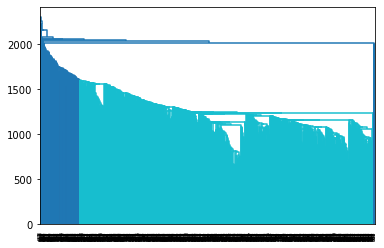

In [6]:
print("Dendogram for single-linkage:")
dendogram(data_without_labels.iloc[:1000, :], method='single')


Dendogram for complete-linkage:


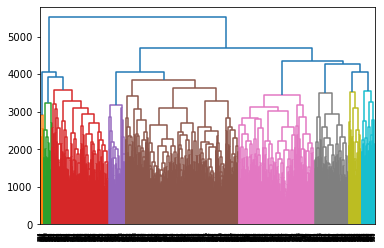

In [7]:
print("\nDendogram for complete-linkage:")
dendogram(data_without_labels.iloc[:1000, :], method='complete')

**Question**: Explain the procedure to find the optimal number of clusters using dendogram

Answer: Optimal number of clusters = 3. Procedure:
1. Plot the dendogram of the given data
2. In the graph, locate the largest vertical distance between the nodes (where no new nodes are created)
3. Draw a horizontal line in this region. The number of vertical lines (clusters) that intersect this horizontal line will be the optimal number of clusters.

In the above graph, the region with largest vertical distance is the one that ranges from 80000-100000 (approximately), since the number of clusters that cut the horizontal line is 3, optimal number of clusters = 3





In [54]:
labels_single = hierarchical_clustering(X=data_without_labels.iloc[:1000, :], no_of_clusters=3, linkage='single')
labels_complete = hierarchical_clustering(X=data_without_labels.iloc[:1000, :], no_of_clusters=3, linkage='complete')


In [44]:
#visualisation of clusters using single linkage and complete linkage
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(data_without_labels.iloc[:1000, :])

type(X_2d)
# plt.scatter(data_without_labels[labels==0, 0], data_pd[labels==0, 1], s=50, marker='o', color='red')
# plt.scatter(data_pd[labels==1, 0], data_pd[labels==1, 1], s=50, marker='o', color='blue')
# plt.scatter(data_pd[labels==2, 0], data_pd[labels==2, 1], s=50, marker='o', color='green')
# # plt.scatter(X[labels==3, 0], X[labels==3, 1], s=50, marker='o', color='purple')
# # plt.scatter(X[labels==4, 0], X[labels==4, 1], s=50, marker='o', color='orange')
# plt.show()


numpy.ndarray

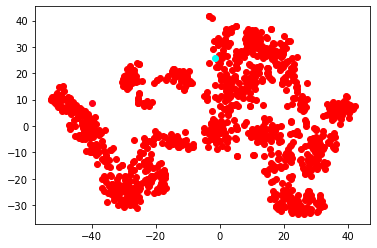

In [56]:
data_clusters = {}
for i in range(3):
    data_clusters[i] = []
for i in range(len(labels_single)):
    data_clusters[labels_single[i]].append(X_2d[i, :])
for i in range(3):
    data_clusters[i] = np.array(data_clusters[i])

# target_ids = range(len(labels_ordered))

from matplotlib import pyplot as plt
hsv = plt.get_cmap('hsv')
colors = hsv(np.linspace(0, 1.0, len(set(labels_single))))
for label, color in zip(set(labels_single), colors):
    plt.scatter(data_clusters[label][:, 0], data_clusters[label][:, 1], c = np.array([color]), label=label)

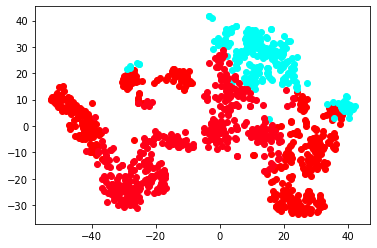

In [47]:
data_clusters = {}
for i in range(3):
    data_clusters[i] = []
for i in range(len(labels_complete)):
    data_clusters[labels_complete[i]].append(X_2d[i, :])
for i in range(3):
    data_clusters[i] = np.array(data_clusters[i])

# target_ids = range(len(labels_ordered))

from matplotlib import pyplot as plt
hsv = plt.get_cmap('hsv')
colors = hsv(np.linspace(0, 1.0, len(set(labels_complete))))
for label, color in zip(set(labels_complete), colors):
    plt.scatter(data_clusters[label][:, 0], data_clusters[label][:, 1], c = np.array([color]), label=label)

In [40]:
'''
Just testing the data and clustering - Not a deliverable
'''
model = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='single', compute_full_tree=True, distance_threshold=2100)
model.fit(data_without_labels.iloc[:1000, :])
print(set(model.labels_))
labels_c = model.labels_


{0, 1, 2, 3, 4, 5}


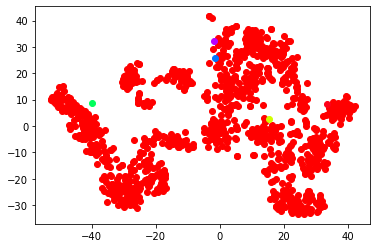

In [42]:
'''
Just testing the data and clustering - Not a deliverable
'''
data_clusters = {}
for i in range(6):
    data_clusters[i] = []
for i in range(len(labels_c)):
    data_clusters[labels_c[i]].append(X_2d[i, :])
for i in range(6):
    data_clusters[i] = np.array(data_clusters[i])

# target_ids = range(len(labels_ordered))

from matplotlib import pyplot as plt
hsv = plt.get_cmap('hsv')
colors = hsv(np.linspace(0, 1.0, len(set(labels_c))))
for label, color in zip(set(labels_c), colors):
    plt.scatter(data_clusters[label][:, 0], data_clusters[label][:, 1], c = np.array([color]), label=label)

In [23]:
data_without_labels.head(5)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,9,8,0,...,103,87,56,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,14,53,99,17,...,0,0,0,0,63,53,31,0,0,0
3,0,0,0,0,0,0,0,0,0,161,...,137,126,140,0,133,224,222,56,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Question:** Mention the differences observed using single and complete linkage:

Answer: Single linkage has very poor output, it wasn't able to properly seperate the clusters. This could be because the data points are very close to each other. Since most points are quite close to each other, this bottom-up approach clustering via single linkage (distance between the closest points) will often be rendered useless. It is also difficult to plot a proper dendogram in case of single-linkage due to which identification of optimal number of clusters is tough.

In case of complete linkage, we obtained a much better quality clustering output. Complete linkage can perform clustering even when data points are close to each other. The given data has closely packed data points, hence the clustering worked well with complete-linkage (unlike single-linkage)